# Instragram Data Visualization
An IPython notebook to visualize my (or anybody elses) activity on Instagram.
My Instagram account: [radikahl](https://www.instagram.com/radikahl/)

In [1]:
# data vis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data load imports
import requests
import json

%matplotlib inline

In [2]:
# username of Instragram user you want to run the script on
USERNAME = 'radikahl'

# Google Maps key. Needed to translate location names into Geo positions
MAPS_API_KEY = 'YOUR_KEY'

# Google Maps' API endpoint
MAPS_API_URL = 'https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'

# Instagram's API endpoint
INSTAGRAM_URL = 'http://instagram.com/{0}/media'

# data dumps
json_file = 'data/instagram_posts.json'
csv_file = 'data/instagram_posts.csv'

# Graph Config
title_fontsize = 16

## Pull Data from Instagram

In [3]:
def extractDataFromInstagram(username):
    data = []
    max_id = None
    more_available = True

    while more_available:
        url = INSTAGRAM_URL
        
        if max_id is not None:
            url += '?max_id=' + max_id
            
        response = requests.get(url.format(username))
        media = response.json()
        data.append(media)
        
        numAllPosts = len(data)
        numAllPosts = sum(len(s['items']) for s in data)
        if max_id is None:
            print('Loaded', end=' ')

        print(numAllPosts, end=' ')
        
        more_available = False
        if 'more_available' in media and media['more_available'] is True:
            max_id = media['items'][-1]['id']
            more_available = True

    return data

data = extractDataFromInstagram(USERNAME)

Loaded 20 40 60 80 100 116 

In [4]:
with open(json_file, 'w') as f:
    f.write(json.dumps(data, indent=2))

## Load Data into Dataframe

In [5]:
def loadDataIntoDataFrame(media):
    id,link,type,creation_time,likes,comments,location,body = [],[],[],[],[],[],[],[]
    for item in media['items']:
        #print(item['link'], item['type'])
        id.append(item['id'])
        link.append(item['link'])
        type.append(item['type'])
        creation_time.append(item['created_time'])
        likes.append(item['likes']['count'])
        comments.append(item['comments']['count'])
        if item['location'] is not None:
            location.append(item['location']['name'])
        else:
            location.append(np.nan)
        if item['caption'] is not None:
            body.append(item['caption']['text'])
        else:
            body.append('')

    df = pd.DataFrame(data = [id,link,type,creation_time,likes,comments,location,body]).T
    df.columns = ['id','link','type','creation_time','likes','comments','location','body']
    #df = df.set_index('id')
    df['type'] = df['type'].astype('category', categories=['image', 'video'])
    df['creation_time'] = pd.to_datetime(df['creation_time'].astype(int), unit='s')
    df[['likes', 'comments']] = df[['likes', 'comments']].astype(int)
    
    return df

In [6]:
df = pd.DataFrame()
for chunk in data:
    df = df.append(loadDataIntoDataFrame(chunk))
df = df.reset_index(drop=True)

In [7]:
# save dataframe as csv
df.to_csv(csv_file, index=False, encoding='utf-8')

### Data Preparation
Adding additional columns used in visualizations later

In [8]:
df['hour'] = df['creation_time'].dt.hour
df['weekday'] = df['creation_time'].dt.weekday
df['year-month'] = df['creation_time'].map(lambda x: '{0}-{1:02}'.format(x.year, x.month))

## Visualizing my Posting Activity

### Posts by Hour

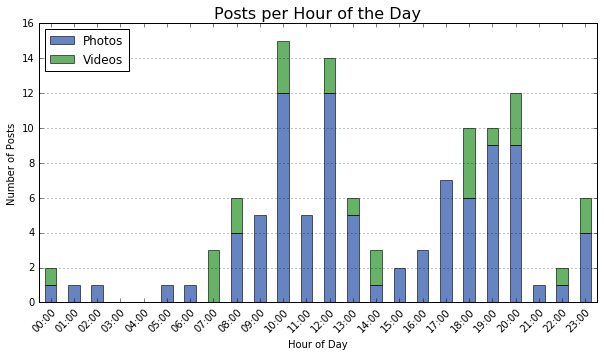

In [9]:
hour_group = df[['hour', 'type', 'link']].groupby(['hour', 'type']).count()
hour_group = hour_group.unstack()

# adding missing hours (aka no posts)
idx = pd.date_range("0:00", "23:00", freq="H").hour
hour_group = hour_group.reindex(idx)
hour_group = hour_group.fillna(0)

plot = hour_group.plot(kind='bar', 
                       stacked=True, 
                       figsize=[10, 5],
                       alpha=0.6,
                       color=['#003399', 'g'],
                       edgecolor='k', 
                       grid=False)
plot.set_title('Posts per Hour of the Day', fontsize=title_fontsize)
plot.set_ylabel('Number of Posts')
plot.set_xlabel('Hour of Day')
xlabels = ['{:02}:00'.format(x) for x in hour_group.index]
plot.set_xticks(range(len(xlabels)))
plot.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')
plot.legend(["Photos", "Videos"], loc=2, ncol=1)
plot.yaxis.grid(True)

plt.savefig('images/instagram_posts_hour.png', dpi=96, bbox_inches='tight')
plt.show()

### Posts by Day of Week

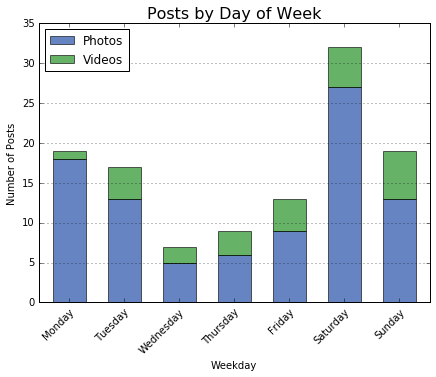

In [10]:
weekday_group = df[['weekday', 'type', 'link']].groupby(['weekday','type']).count()

weekday_group.index = weekday_group.index.set_levels(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    level=0)

plot = weekday_group.unstack().plot(kind='bar', 
                                    stacked=True, 
                                    figsize=[7, 5], 
                                    width=0.6, 
                                    alpha=0.6, 
                                    color=['#003399', 'g'],
                                    edgecolor='k', 
                                    grid=False)
plot.set_title('Posts by Day of Week', fontsize=title_fontsize)
plot.set_ylabel("Number of Posts")
plot.set_xlabel("Weekday")
plot.set_xticklabels(weekday_group.index.levels[0], rotation=45, 
                     rotation_mode='anchor', ha='right')
plot.legend(["Photos", "Videos"], loc=2, ncol=1)
plot.yaxis.grid(True)

plt.savefig('images/instagram_posts_weekday.png', dpi=96, bbox_inches='tight')
plt.show()

### Posts by Month

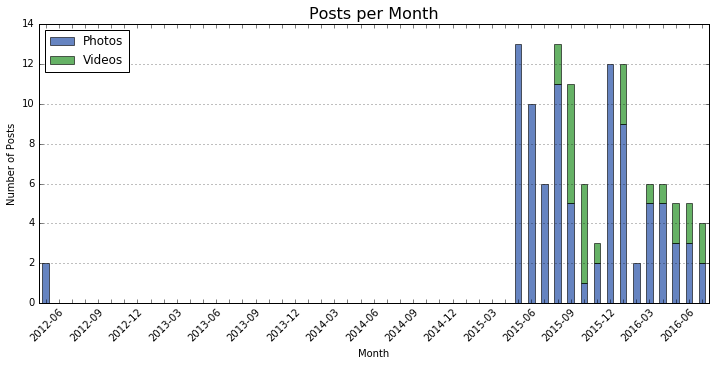

In [11]:
month_group = df[['year-month', 'type', 'link']].groupby(['year-month', 'type']).count()
month_group = month_group.unstack()

# adding missing hours (aka no posts)
months = pd.Period(df['year-month'].max(), freq='M') - pd.Period(df['year-month'].min(), freq='M') + 1
idx = pd.date_range(start=df['year-month'].min(), 
                    periods=months, 
                    freq="M") \
                   .map(lambda x: '{0}-{1:02}'.format(x.year, x.month))
month_group = month_group.reindex(idx)
month_group = month_group.fillna(0)

plot = month_group.plot(kind='bar', 
                       stacked=True, 
                       figsize=[12, 5],
                       alpha=0.6,
                       color=['#003399', 'g'],
                       edgecolor='k', 
                       align='center',
                       grid=False)
plot.set_title('Posts per Month', fontsize=title_fontsize)
plot.set_ylabel('Number of Posts')
plot.set_xlabel('Month')
xlabels = month_group.iloc[range(1, len(month_group), 3)].index
xlabels = [x if x in xlabels else '' for x in month_group.index]
plot.set_xticks(range(len(xlabels)))
plot.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')
plot.legend(["Photos", "Videos"], loc=2, ncol=1)
plot.yaxis.grid(True)

plt.savefig('images/instagram_posts_month.png', dpi=96, bbox_inches='tight')
plt.show()

## Vizualizing Engagement

### Average Engagement per Post

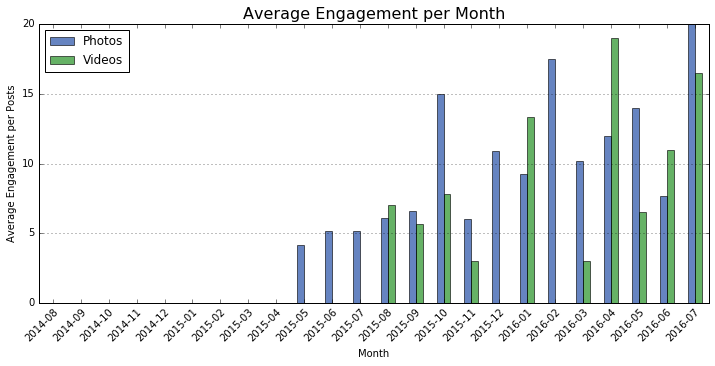

In [12]:
month_group = df[['year-month', 'type', 'likes', 'comments','link']].copy()
month_group['engagement'] = month_group['likes'] + month_group['comments']
month_group = month_group.drop(['likes', 'comments'], axis=1)
month_group = month_group.groupby(['year-month', 'type'])

months = pd.Period(df['year-month'].max(), freq='M') - pd.Period(df['year-month'].min(), freq='M') + 1
idx = pd.date_range(start=df['year-month'].min(), 
                    periods=months, 
                    freq="M") \
                   .map(lambda x: '{0}-{1:02}'.format(x.year, x.month))

month_mean = month_group.mean()
month_mean = month_mean.unstack().reindex(idx).fillna(0)[-24:]

plot = month_mean.plot(kind='bar', 
                       stacked=False, 
                       figsize=[12, 5],
                       alpha=0.6,
                       color=['#003399', 'g'],
                       edgecolor='k', 
                       align='center',
                       grid=False)
plot.set_title('Average Engagement per Month', fontsize=title_fontsize)
plot.set_ylabel('Average Engagement per Posts')
plot.set_xlabel('Month')
plot.set_xticklabels(month_mean.index, rotation=45, rotation_mode='anchor', ha='right')
plot.legend(["Photos", "Videos"], loc=2, ncol=1)
plot.yaxis.grid(True)

plt.savefig('images/instagram_average_engagement_month.png', dpi=96, bbox_inches='tight')
plt.show()

## Visualzing Tags

### Most Commonly Used Hashtags

In [13]:
df['tags'] = df['body'].str.findall('(#\w+)')
# count number of tags per post
#df['num_tags'] = dfc['tags'].map(len)

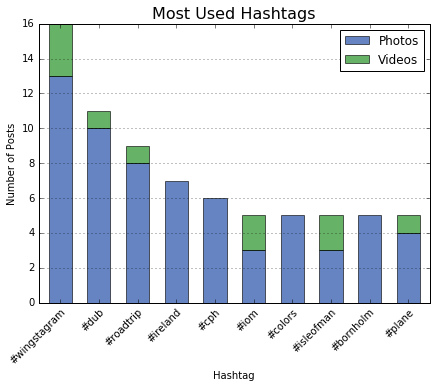

In [14]:
# splitting the hashtag list in individual rows
df_tags = df.groupby('id')['tags'].apply(lambda x: pd.DataFrame(x.values[0])) \
                                  .reset_index() \
                                  .drop('level_1', axis=1)
df_tags.columns = ['id', 'tag']

# merge with main df to get type info
df_tags = pd.merge(df_tags, df[['id', 'type']], on='id')

hashtag_group = df_tags.groupby(['tag', 'type']).count()
hashtag_group = hashtag_group.unstack().fillna(0)
hashtag_group['all'] = hashtag_group['id']['image'] \
                     + hashtag_group['id']['video']
hashtag_group = hashtag_group.sort_values(by='all', ascending=False) \
                             .head(10).drop('all', axis=1)

plot = hashtag_group.plot(kind='bar', 
                          stacked=True, 
                          figsize=[7, 5], 
                          width=0.6, 
                          alpha=0.6, 
                          color=['#003399', 'g'],
                          edgecolor='k', 
                          grid=False)
plot.set_title('Most Used Hashtags', fontsize=title_fontsize)
plot.set_ylabel("Number of Posts")
plot.set_xlabel("Hashtag")
plot.set_xticklabels(hashtag_group.index, rotation=45, 
                     rotation_mode='anchor', ha='right')
plot.legend(["Photos", "Videos"], loc=1, ncol=1)
plot.yaxis.grid(True)

plt.savefig('images/instagram_most_common_hashtags.png', dpi=96, bbox_inches='tight')
plt.show()